In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.max_columns = 200

from matplotlib import rcParams
rcParams['figure.figsize'] = 14, 12
rcParams['font.size'] = 16
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 13
rcParams['ytick.labelsize'] = 13
rcParams['legend.fontsize'] = 15

import seaborn as sns
sns.set_style("whitegrid")
import os
import sys
import json

import cv2
from tqdm import tqdm

from imgaug import augmenters as aug
from sklearn.model_selection import StratifiedKFold, KFold

# скачиваем Mask rcnn, предтренировочные веса

In [107]:
!git clone https://www.github.com/matterport/Mask_RCNN.git

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [108]:
os.getcwd()

'C:\\Users\\dzhal\\Downloads\\Mask_RCNN'

In [104]:
sys.path.append(r'C:\Users\dzhal\Downloads\Mask_RCNN\Mask_RCNN')
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Set Config

In [7]:
IMAGE_SIZE = 512

class Fashion_Config(Config):
    NAME = "fashion"
    BACKBONE = 'resnet50'# используемая модель
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE
    IMAGES_PER_GPU = 1 #комп не тянет больше
    IMAGE_RESIZE_MODE = 'none'
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    NUM_CLASSES = 46
    GPU_COUNT = 1
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 200
    
    
config = Fashion_Config()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [109]:
dataset_dir = 'D:/new_downloads/clothes/'
with open(dataset_dir + "label_descriptions.json") as f:
    label_descriptions = json.load(f)

label_names = [x['name'] for x in label_descriptions['categories']]

In [116]:
segment_df = pd.read_csv(dataset_dir + "train.csv")

multilabel_percent = len(segment_df[segment_df['ClassId'].str.contains('_')])/len(segment_df)*100
print(f"дополнительные атрибуты: {multilabel_percent:.2f}%")

дополнительные атрибуты: 3.47%


In [111]:
segment_df['CategoryId'] = segment_df['ClassId'].str.split('_').str[0]

print("Total segments: ", len(segment_df))
segment_df.head()

Total segments:  331213


,ImageId,EncodedPixels,Height,Width,ClassId,CategoryId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,32


In [112]:
images = segment_df.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x))
sizes = segment_df.groupby('ImageId')['Height', 'Width'].mean()# mean просто так, можно было взять первый элемент
images = images.join(sizes, on='ImageId')

print("Total images: ", len(images))
images.head()

Total images:  45195


,EncodedPixels,CategoryId,Height,Width
ImageId,,,,
00000663ed1ff0c4e0132b9b9ac53f6e.jpg,[6068157 7 6073371 20 6078584 34 6083797 48 60...,"[6, 0, 28, 31, 32, 32, 31, 29, 4]",5214,3676
0000fe7c9191fba733c8a69cfaf962b7.jpg,[2201176 1 2203623 3 2206071 5 2208518 8 22109...,"[33, 1]",2448,2448
0002ec21ddb8477e98b2cbb87ea2e269.jpg,[2673735 2 2676734 8 2679734 13 2682733 19 268...,"[33, 10, 23, 23]",3000,1997
0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,[435 132 1002 132 1569 132 2136 132 2703 132 3...,"[10, 33, 15]",567,400
0004467156e47b0eb6de4aa6479cbd15.jpg,[132663 8 133396 25 134130 41 134868 53 135611...,"[10, 33, 31, 31, 15]",750,500


In [113]:
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

In [114]:
class Fashion_Dataset(utils.Dataset):

    def __init__(self, df):
        super().__init__(self)
        
        for i, name in enumerate(label_names):
            self.add_class("fashion", i+1, name)
        
        for i, row in df.iterrows():
            self.add_image("fashion", 
                           image_id=row.name, 
                           path=str(dataset_dir + 'train' + row.name), 
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [label_names[int(x)] for x in info['labels']]
    
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)

In [115]:
dataset = Fashion_Dataset(images)
dataset.prepare()

In [15]:
kf = KFold(n_splits=5, random_state=0, shuffle=True)
splits = kf.split(images) # ideally, this should be multilabel stratification

def get_fold():    
    for i, (train_index, valid_index) in enumerate(splits):
        if i == 0:
            return images.iloc[train_index], images.iloc[valid_index]
        
train_df, valid_df = get_fold()

train_data = Fashion_Dataset(train_df)
train_data.prepare()

valid_data = Fashion_Dataset(valid_df)
valid_data.prepare()

# Train

In [17]:
LR = 1e-4

import warnings 
warnings.filterwarnings("ignore")

In [18]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir='C:/Users/dzhal/Downloads')

model.load_weights('C:/Users/dzhal/Downloads/mask_rcnn_coco.h5', by_name=True, exclude=[
    'mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])

In [19]:
augmentation = aug.Sequential([
    aug.Fliplr(0.5) # only horizontal flip here
])

## Transfer learning

### сначала обучаем выход

In [20]:
model.train(train_data, valid_data,
            learning_rate=LR*2, # train heads with higher lr to speedup learning
            epochs=2,
            layers='heads',
            augmentation=None)

history = model.keras_model.history.history


Starting at epoch 0. LR=0.0002

Checkpoint Path: C:/Users/dzhal/Downloads\fashion20200211T1022\mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mas

In [22]:
# устал обучать, модель недообучена, но суть я думаю понятна
model.train(train_data, valid_data,
            learning_rate=LR,
            epochs=6,
            layers='all',
            augmentation=augmentation)

history_new = model.keras_model.history.history
for k in history_new:
    history[k] = history[k] + history_new[k]


Starting at epoch 2. LR=0.0001

Checkpoint Path: C:/Users/dzhal/Downloads\fashion20200211T1022\mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_bran

KeyboardInterrupt: 

In [ ]:
model.train(train_data, valid_data,
            learning_rate=LR/5,
            epochs=8,
            layers='all',
            augmentation=augmentation)

history_new = model.keras_model.history.history
for k in history_new:
    history[k] = history[k] + history_new[k]

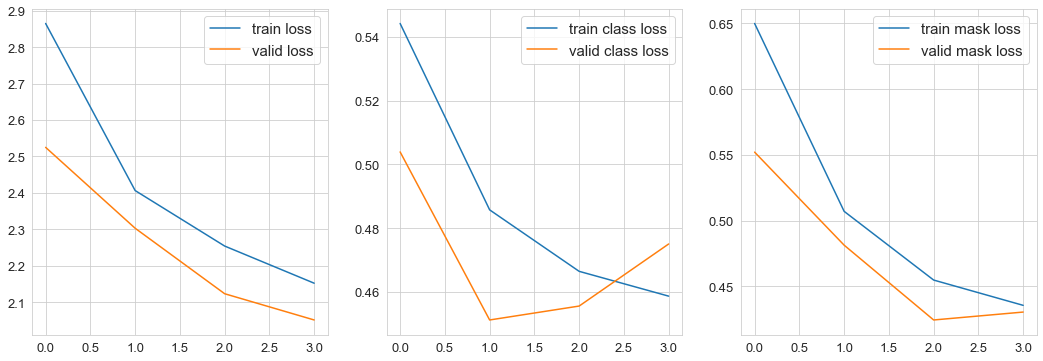

In [119]:
epochs = range(4)

plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.plot(epochs, history['loss'], label="train loss")
plt.plot(epochs, history['val_loss'], label="valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history['mrcnn_class_loss'], label="train class loss")
plt.plot(epochs, history['val_mrcnn_class_loss'], label="valid class loss")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history['mrcnn_mask_loss'], label="train mask loss")
plt.plot(epochs, history['val_mrcnn_mask_loss'], label="valid mask loss")
plt.legend()

plt.show()

In [120]:
best_epoch = np.argmin(history["val_loss"]) + 1
print("Best epoch: ", best_epoch)
print("Valid loss: ", history["val_loss"][best_epoch-1])

Best epoch:  4
Valid loss:  2.0509696170687675


# Predict

In [39]:
model = modellib.MaskRCNN(mode='inference', 
                          config=fashion_config(),
                          model_dir="C:\Users\dzhal\Downloads")

model.load_weights(r"C:\Users\dzhal\Downloads\fashion20200211T1022\mask_rcnn_fashion_0004.h5", by_name=True)

Re-starting from epoch 4


In [42]:
# декод масок
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

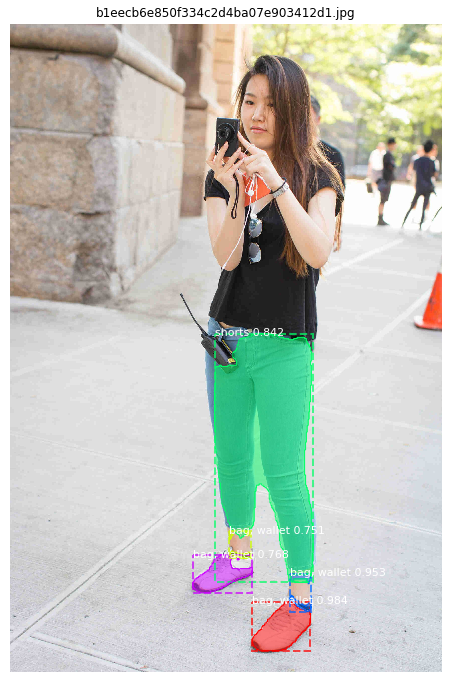

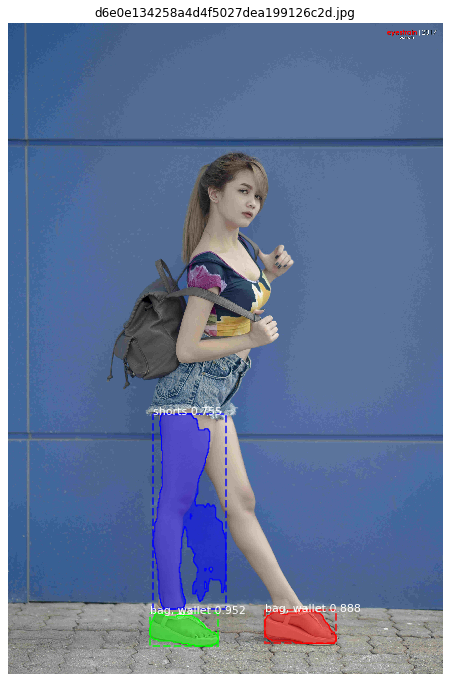

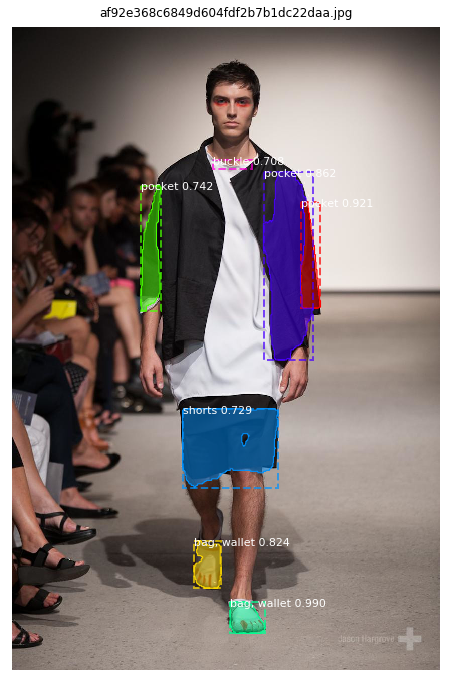

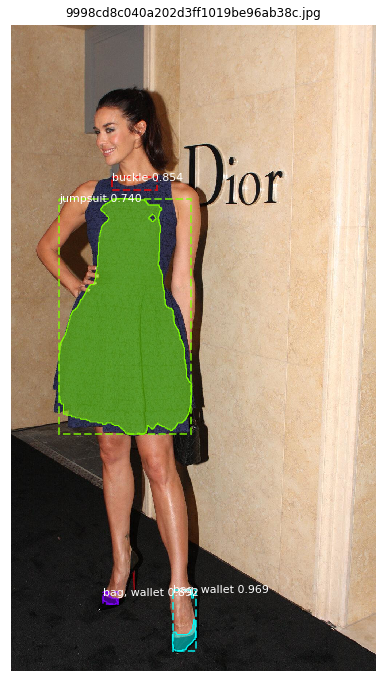

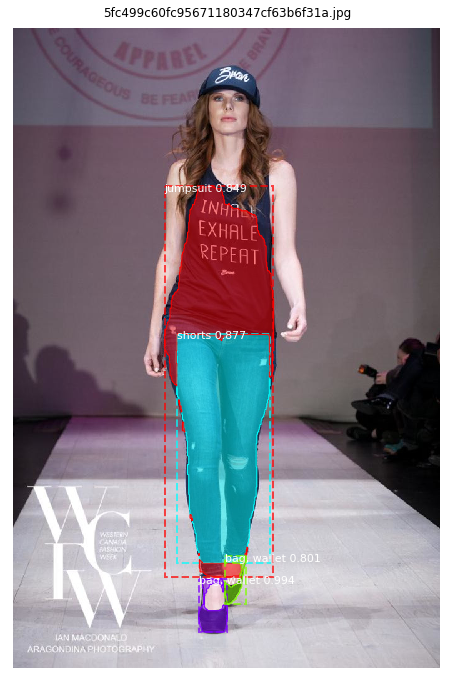

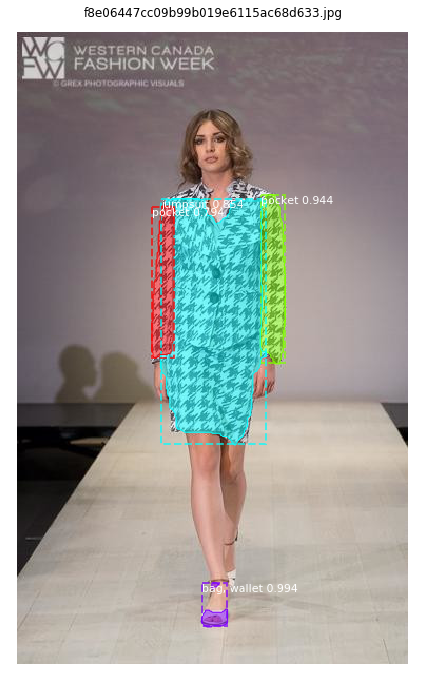

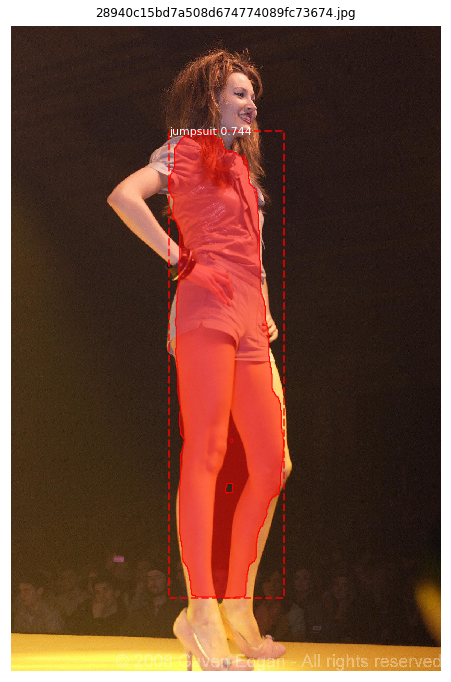


*** No instances to display *** 



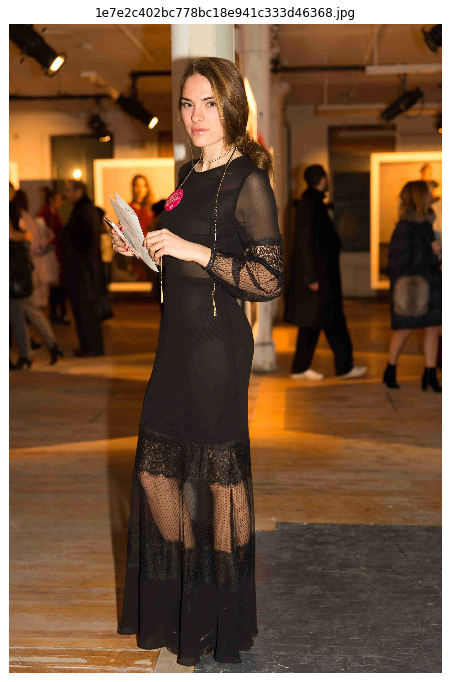

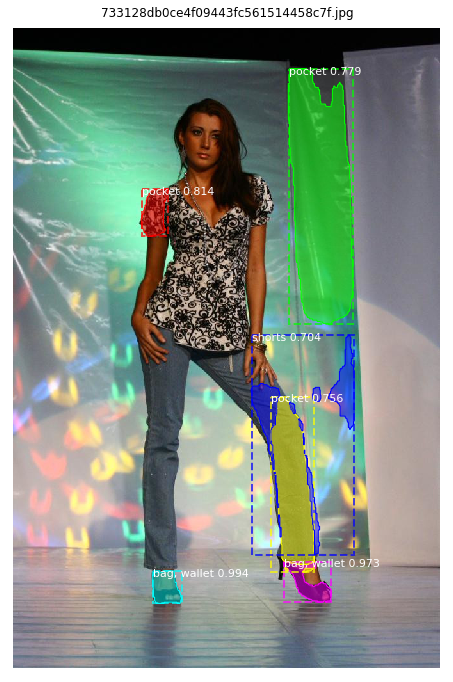

In [103]:
for i in range(9):
    image_id = sample_df.sample()['ImageId'].values[0]
    image_path = str(dataset_dir + 'test' + image_id)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = model.detect([resize_image(image_path)])
    res = result[0]
    
    if res['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], res['masks'].shape[-1]), dtype=np.uint8)
        for m in range(res['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(res['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = img.shape[0]/IMAGE_SIZE
        x_scale = img.shape[1]/IMAGE_SIZE
        rois = (res['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        
        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = res['masks'], res['rois']
        
    visualize.display_instances(img, rois, masks, res['class_ids'], 
                                label_names, res['scores'],
                                title=image_id, figsize=(12, 12))

## модель не дообучена очевидно, но не вижу тратить еще пару дней на дообучение